In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.callbacks import Callback,EarlyStopping

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/DeepLearningProject/SurfaceCracks/'
path_all = list(glob.glob(path+'**/*jpg'))
path_Negative = path + 'Negative/*.jpg'
path_Positive = path + 'Positive/*.jpg'

In [ ]:
labels = list(map(lambda x:os.path.split(os.path.split(x)[0])[1], path_all))
file_Path = pd.Series(path_all, name='File_Path').astype(str)
labels = pd.Series(labels, name='Label')
data = pd.concat([file_Path, labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.head()

,File_Path,Label
0,/content/drive/MyDrive/DeepLearningProject/Sur...,Positive
1,/content/drive/MyDrive/DeepLearningProject/Sur...,Positive
2,/content/drive/MyDrive/DeepLearningProject/Sur...,Positive
3,/content/drive/MyDrive/DeepLearningProject/Sur...,Positive
4,/content/drive/MyDrive/DeepLearningProject/Sur...,Negative


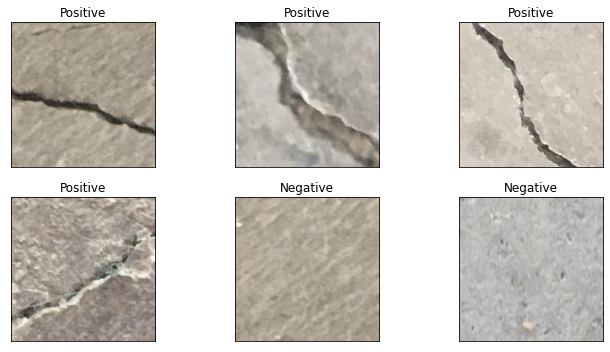

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3,figsize=(10,5), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data.File_Path[i]))
    ax.set_title(data.Label[i])
plt.tight_layout()
plt.show()

In [ ]:
train_df, test_df = train_test_split(data, test_size=0.2, random_state=42)

In [ ]:
def gen(pre,train,test):
    train_datagen = ImageDataGenerator(
                        preprocessing_function=pre,
                        validation_split=0.2)
    test_datagen = ImageDataGenerator(
                        preprocessing_function=pre)
    
    train_gen = train_datagen.flow_from_dataframe(
        dataframe=train,
        x_col='File_Path',
        y_col='Label',
        target_size=(100,100),
        class_mode='categorical',
        batch_size=64,
        shuffle=True,
        seed=42
        )
    valid_gen = train_datagen.flow_from_dataframe(
        dataframe=train,
        x_col='File_Path',
        y_col='Label',
        target_size=(100,100),
        class_mode='categorical',
        batch_size=64,
        shuffle=False,
        seed=42
    )
    test_gen = test_datagen.flow_from_dataframe(
        dataframe=test,
        x_col='File_Path',
        y_col='Label',
        target_size=(100,100),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=64,
        shuffle=False
    )
    return train_gen, valid_gen, test_gen

In [ ]:
def func(name_model):
    pre_model = name_model(input_shape=(100,100, 3),
                   include_top=False,
                   weights='imagenet',
                   pooling='avg')
    pre_model.trainable = False
    inputs = pre_model.input

    x = Dense(64, activation='relu')(pre_model.output)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(2, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss = 'categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
    my_callbacks  = [EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=1,
                              mode='auto')]
    return model, my_callbacks

In [ ]:
def plot(history,df_test,test_gen,train_gen):
    # Plotting Accuracy, val_accuracy, loss, val_loss
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    ax = ax.ravel()

    for i, met in enumerate(['accuracy', 'loss']):
        ax[i].plot(history.history[met])
        ax[i].plot(history.history['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['train', 'val'])
        
    # Predict Data Test
    pred = model.predict(test_gen )
    pred = np.argmax(pred,axis=1)
    labels = (train_gen.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]
    
    # Classification report
    cm=confusion_matrix(df_test.Label,pred)
    clr = classification_report(df_test.Label, pred, target_names=["NEGATIVE", "POSITIVE"])
    print(clr)
    # Display 6 picture of the dataset with their labels
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(plt.imread(df_test.File_Path.iloc[i+1]))
        ax.set_title(f"True: {df_test.Label.iloc[i+1]}\nPredicted: {pred[i+1]}")
    plt.tight_layout()
    plt.show()
        
    return history

In [ ]:
def result_test(test,model_use):
    results = model_use.evaluate(test, verbose=0)
    
    print("Test Loss: {:.5f}".format(results[0]))
    print("Test Accuracy: {:.2f}%".format(results[1] * 100))
    
    return results

1. VGG16

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
model, callback=func(VGG16)

vgg_pre=preprocess_input
train_gen_VGG, valid_gen_VGG, test_gen_VGG = gen(vgg_pre,train_df,test_df)

Found 8006 validated image filenames belonging to 2 classes.
Found 8006 validated image filenames belonging to 2 classes.
Found 2002 validated image filenames belonging to 2 classes.


In [ ]:
history = model.fit(
    train_gen_VGG,
    validation_data=valid_gen_VGG,
    epochs=4,
    callbacks=callback
)

Epoch 1/4
126/126 [==============================] - 39s 291ms/step - loss: 0.0459 - accuracy: 0.9811 - val_loss: 0.0061 - val_accuracy: 0.9984
Epoch 2/4
126/126 [==============================] - 37s 293ms/step - loss: 0.0073 - accuracy: 0.9974 - val_loss: 0.0034 - val_accuracy: 0.9991
Epoch 3/4
126/126 [==============================] - 37s 291ms/step - loss: 0.0032 - accuracy: 0.9990 - val_loss: 0.0016 - val_accuracy: 0.9998
Epoch 4/4
126/126 [==============================] - 36s 290ms/step - loss: 0.0018 - accuracy: 0.9994 - val_loss: 0.0013 - val_accuracy: 0.9999


              precision    recall  f1-score   support

    NEGATIVE       0.99      1.00      1.00       986
    POSITIVE       1.00      1.00      1.00      1016

    accuracy                           1.00      2002
   macro avg       1.00      1.00      1.00      2002
weighted avg       1.00      1.00      1.00      2002



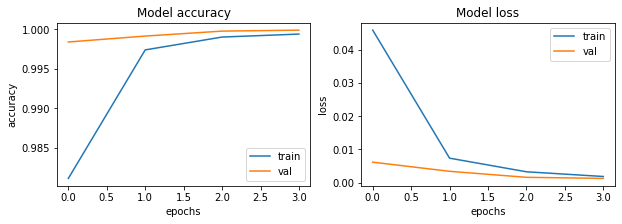

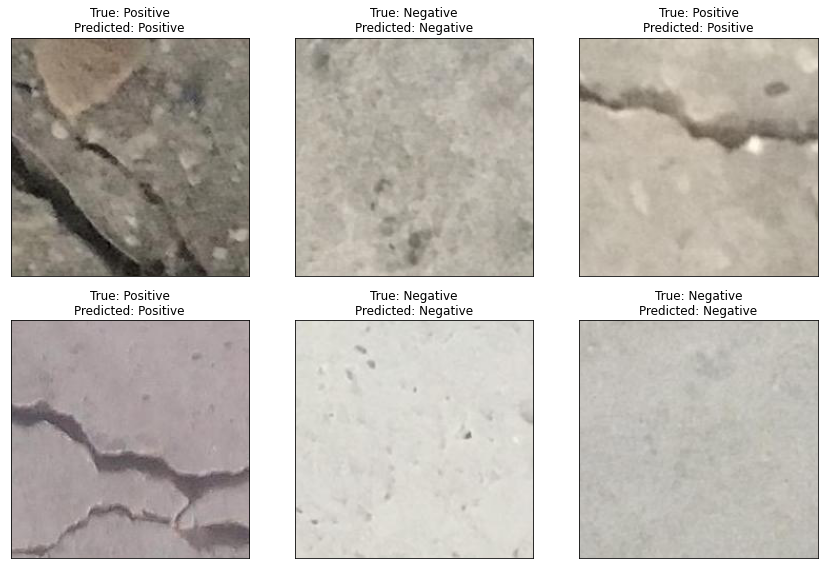

In [ ]:
history=plot(history,test_df,test_gen_VGG,train_gen_VGG)

In [ ]:
result = result_test(test_gen_VGG,model)

Test Loss: 0.00680
Test Accuracy: 99.75%


2. ResNet50

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
ResNet50_model, callback=func(ResNet50)

RestNet_pre=preprocess_input
train_gen_RestNet, valid_gen_RestNet, test_gen_RestNet = gen(RestNet_pre,train_df,test_df)

Found 8006 validated image filenames belonging to 2 classes.
Found 8006 validated image filenames belonging to 2 classes.
Found 2002 validated image filenames belonging to 2 classes.


In [ ]:
history = ResNet50_model.fit(
    train_gen_RestNet,
    validation_data=valid_gen_RestNet,
    epochs=4,
    callbacks=callback
)

Epoch 1/2
126/126 [==============================] - 41s 304ms/step - loss: 0.0205 - accuracy: 0.9921 - val_loss: 0.0168 - val_accuracy: 0.9938
Epoch 2/2
126/126 [==============================] - 37s 293ms/step - loss: 0.0017 - accuracy: 0.9994 - val_loss: 4.9395e-04 - val_accuracy: 0.9999


              precision    recall  f1-score   support

    NEGATIVE       0.99      1.00      1.00       986
    POSITIVE       1.00      1.00      1.00      1016

    accuracy                           1.00      2002
   macro avg       1.00      1.00      1.00      2002
weighted avg       1.00      1.00      1.00      2002



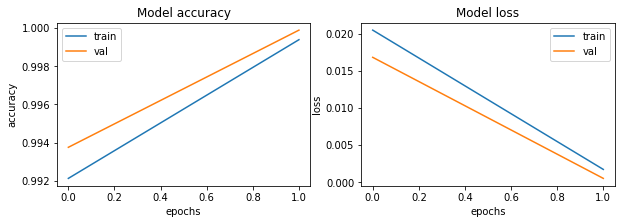

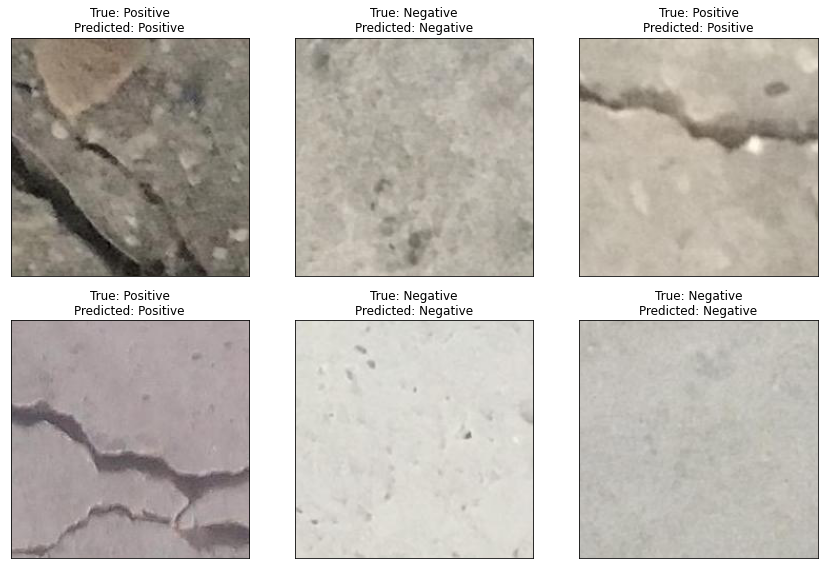

In [ ]:
history_ResNet=plot(history,test_df,test_gen_RestNet,train_gen_RestNet)

In [ ]:
result_ResNet = result_test(test_gen_RestNet,ResNet50_model)

Test Loss: 0.00565
Test Accuracy: 99.75%


3. Xception

In [ ]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input
Xception_model, callback=func(Xception)

Xception_pre=preprocess_input
train_gen_Xception, valid_gen_Xception, test_gen_Xception = gen(Xception_pre,train_df,test_df)

Found 8006 validated image filenames belonging to 2 classes.
Found 8006 validated image filenames belonging to 2 classes.
Found 2002 validated image filenames belonging to 2 classes.


In [ ]:
history = Xception_model.fit(
    train_gen_Xception,
    validation_data=valid_gen_Xception,
    epochs=4,
    callbacks=callback
)

Epoch 1/2
126/126 [==============================] - 39s 291ms/step - loss: 0.0617 - accuracy: 0.9884 - val_loss: 0.0094 - val_accuracy: 0.9974
Epoch 2/2
126/126 [==============================] - 36s 285ms/step - loss: 0.0086 - accuracy: 0.9976 - val_loss: 0.0031 - val_accuracy: 0.9993


              precision    recall  f1-score   support

    NEGATIVE       0.56      1.00      0.71       986
    POSITIVE       1.00      0.22      0.36      1016

    accuracy                           0.61      2002
   macro avg       0.78      0.61      0.54      2002
weighted avg       0.78      0.61      0.54      2002



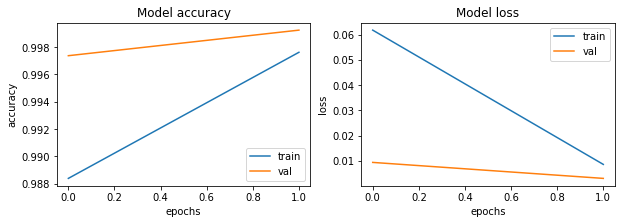

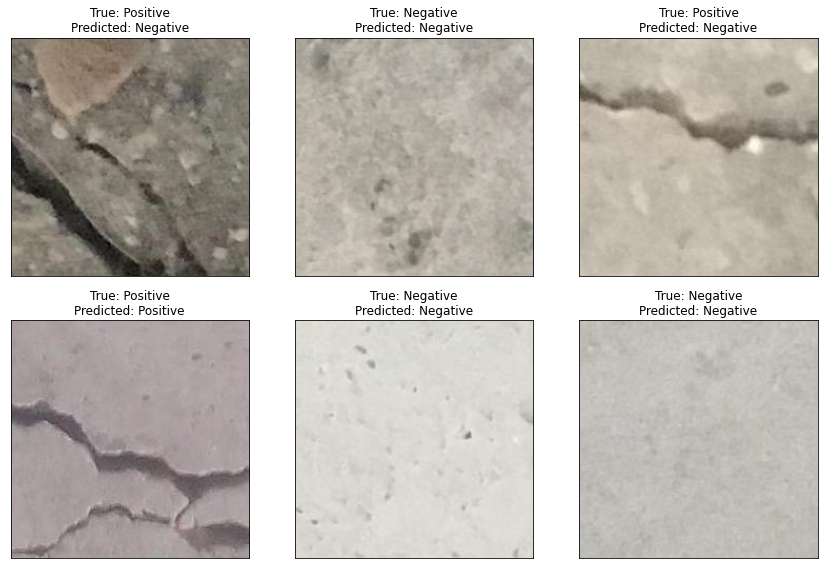

In [ ]:
history_Xception=plot(history,test_df,test_gen_Xception,train_gen_Xception)

In [ ]:
result_Xception = result_test(test_gen_Xception,Xception_model)

Test Loss: 0.01162
Test Accuracy: 99.65%


5. MobileNet

In [ ]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
MobileNet_model, callback=func(MobileNet)

MobileNet_pre=preprocess_input
train_gen_MobileNet, valid_gen_MobileNet, test_gen_MobileNet = gen(MobileNet_pre,train_df,test_df)

Found 8006 validated image filenames belonging to 2 classes.
Found 8006 validated image filenames belonging to 2 classes.
Found 2002 validated image filenames belonging to 2 classes.


In [ ]:
history_MobileNet = MobileNet_model.fit(
    train_gen_MobileNet,
    validation_data=valid_gen_MobileNet,
    epochs=4,
    callbacks=callback
)

Epoch 1/4
126/126 [==============================] - 37s 281ms/step - loss: 0.0562 - accuracy: 0.9773 - val_loss: 0.0088 - val_accuracy: 0.9969
Epoch 2/4
126/126 [==============================] - 34s 271ms/step - loss: 0.0045 - accuracy: 0.9988 - val_loss: 0.0011 - val_accuracy: 0.9998
Epoch 3/4
126/126 [==============================] - 34s 269ms/step - loss: 0.0016 - accuracy: 0.9994 - val_loss: 4.8138e-04 - val_accuracy: 1.0000
Epoch 4/4
126/126 [==============================] - 34s 271ms/step - loss: 5.3635e-04 - accuracy: 1.0000 - val_loss: 2.2739e-04 - val_accuracy: 1.0000


              precision    recall  f1-score   support

    NEGATIVE       0.56      1.00      0.71       986
    POSITIVE       1.00      0.22      0.36      1016

    accuracy                           0.61      2002
   macro avg       0.78      0.61      0.54      2002
weighted avg       0.78      0.61      0.54      2002



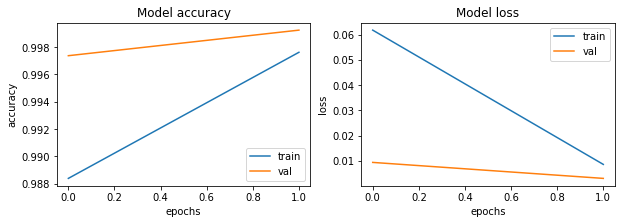

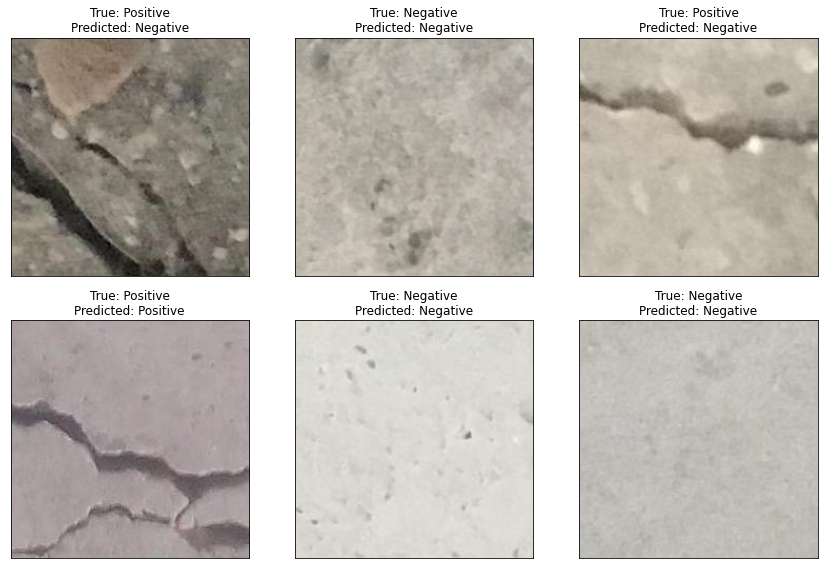

In [ ]:
history=plot(history,test_df,test_gen_MobileNet,train_gen_MobileNet)

In [ ]:
result_MobileNet = result_test(test_gen_MobileNet,MobileNet_model)

Test Loss: 0.00195
Test Accuracy: 99.95%


Final Results

In [ ]:
output = pd.DataFrame({'Model':['VGG16','ResNet50','Xception','MobileNet'],
                      'Accuracy':[result[1], result_ResNet[1], result_Xception[1], result_MobileNet[1]]})

In [ ]:
output

,Model,Accuracy
0,VGG16,0.997503
1,ResNet50,0.997503
2,Xception,0.996503
3,MobileNet,0.999501
